In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
out_dir = os.path.join(data_dir, 'results/LogisticRegressionCV_PCA_Healthy_v_ACVD_Jie_only')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Study Accession"].isin(['PRJEB21528']).to_numpy()
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(282, 38)

In [7]:
SampleMeta["Phenotype"].value_counts()

ACVD           152
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

In [8]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(282, 903)

In [9]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [10]:
X = MatrixData

In [11]:
y = SampleMeta['Phenotype'].to_numpy().astype('str') == 'ACVD'
y = y.astype('int64')

In [12]:
pd.value_counts(SampleMeta['Phenotype'])

ACVD           152
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

# Define and Train Model

In [13]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

retrain = True
n_splits = 5
out_path = os.path.join(out_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(out_dir):
        os.system('rm -rf ' + out_dir)
    os.mkdir(out_dir)
    # random seed here deals with model initialization
    MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
                                         solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
                                        scoring=metrics.make_scorer(RECALL_SCORE))
    MyTrainer = Trainer(model = MyLogistic, scale_X = True, use_pca = True, n_components=100)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()
    


Running for split 1 of 5
Using predict_proba
getting predictions from probs
Running for split 2 of 5
Using predict_proba
getting predictions from probs
Running for split 3 of 5
Using predict_proba
getting predictions from probs
Running for split 4 of 5
Using predict_proba
getting predictions from probs
Running for split 5 of 5
Using predict_proba
getting predictions from probs


In [14]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.818341,train
1,0.816378,train
2,0.788818,train
3,0.847619,train
4,0.839385,train
0,0.806650,test
1,0.706349,test
2,0.652605,test
3,0.777778,test
4,0.751948,test


<AxesSubplot:xlabel='stage', ylabel='score'>

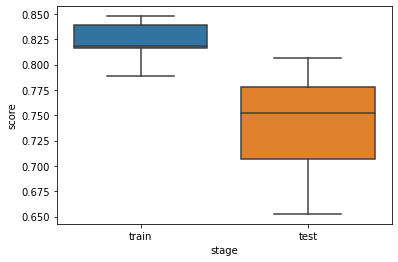

In [15]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [16]:
MyMultiTrainTester.TrainerList[0].model.Cs_

array([2.20264658e+04, 8.10308393e+03, 2.98095799e+03, 1.09663316e+03,
       4.03428793e+02, 1.48413159e+02, 5.45981500e+01, 2.00855369e+01,
       7.38905610e+00, 2.71828183e+00, 1.00000000e+00, 3.67879441e-01,
       1.35335283e-01, 4.97870684e-02, 1.83156389e-02, 6.73794700e-03,
       2.47875218e-03, 9.11881966e-04, 3.35462628e-04, 1.23409804e-04])

In [17]:
hyperparams = {'l1_ratio': [], 'C': []}
for i in range(n_splits):
    hyperparams['l1_ratio'].append(MyMultiTrainTester.TrainerList[i].model.l1_ratio_)
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.C_)

In [18]:
pd.DataFrame(hyperparams)

,l1_ratio,C
0,[0.2],[0.049787068367863944]
1,[0.0],[0.0024787521766663585]
2,[0.5],[0.049787068367863944]
3,[0.0],[0.006737946999085467]
4,[0.9],[0.1353352832366127]


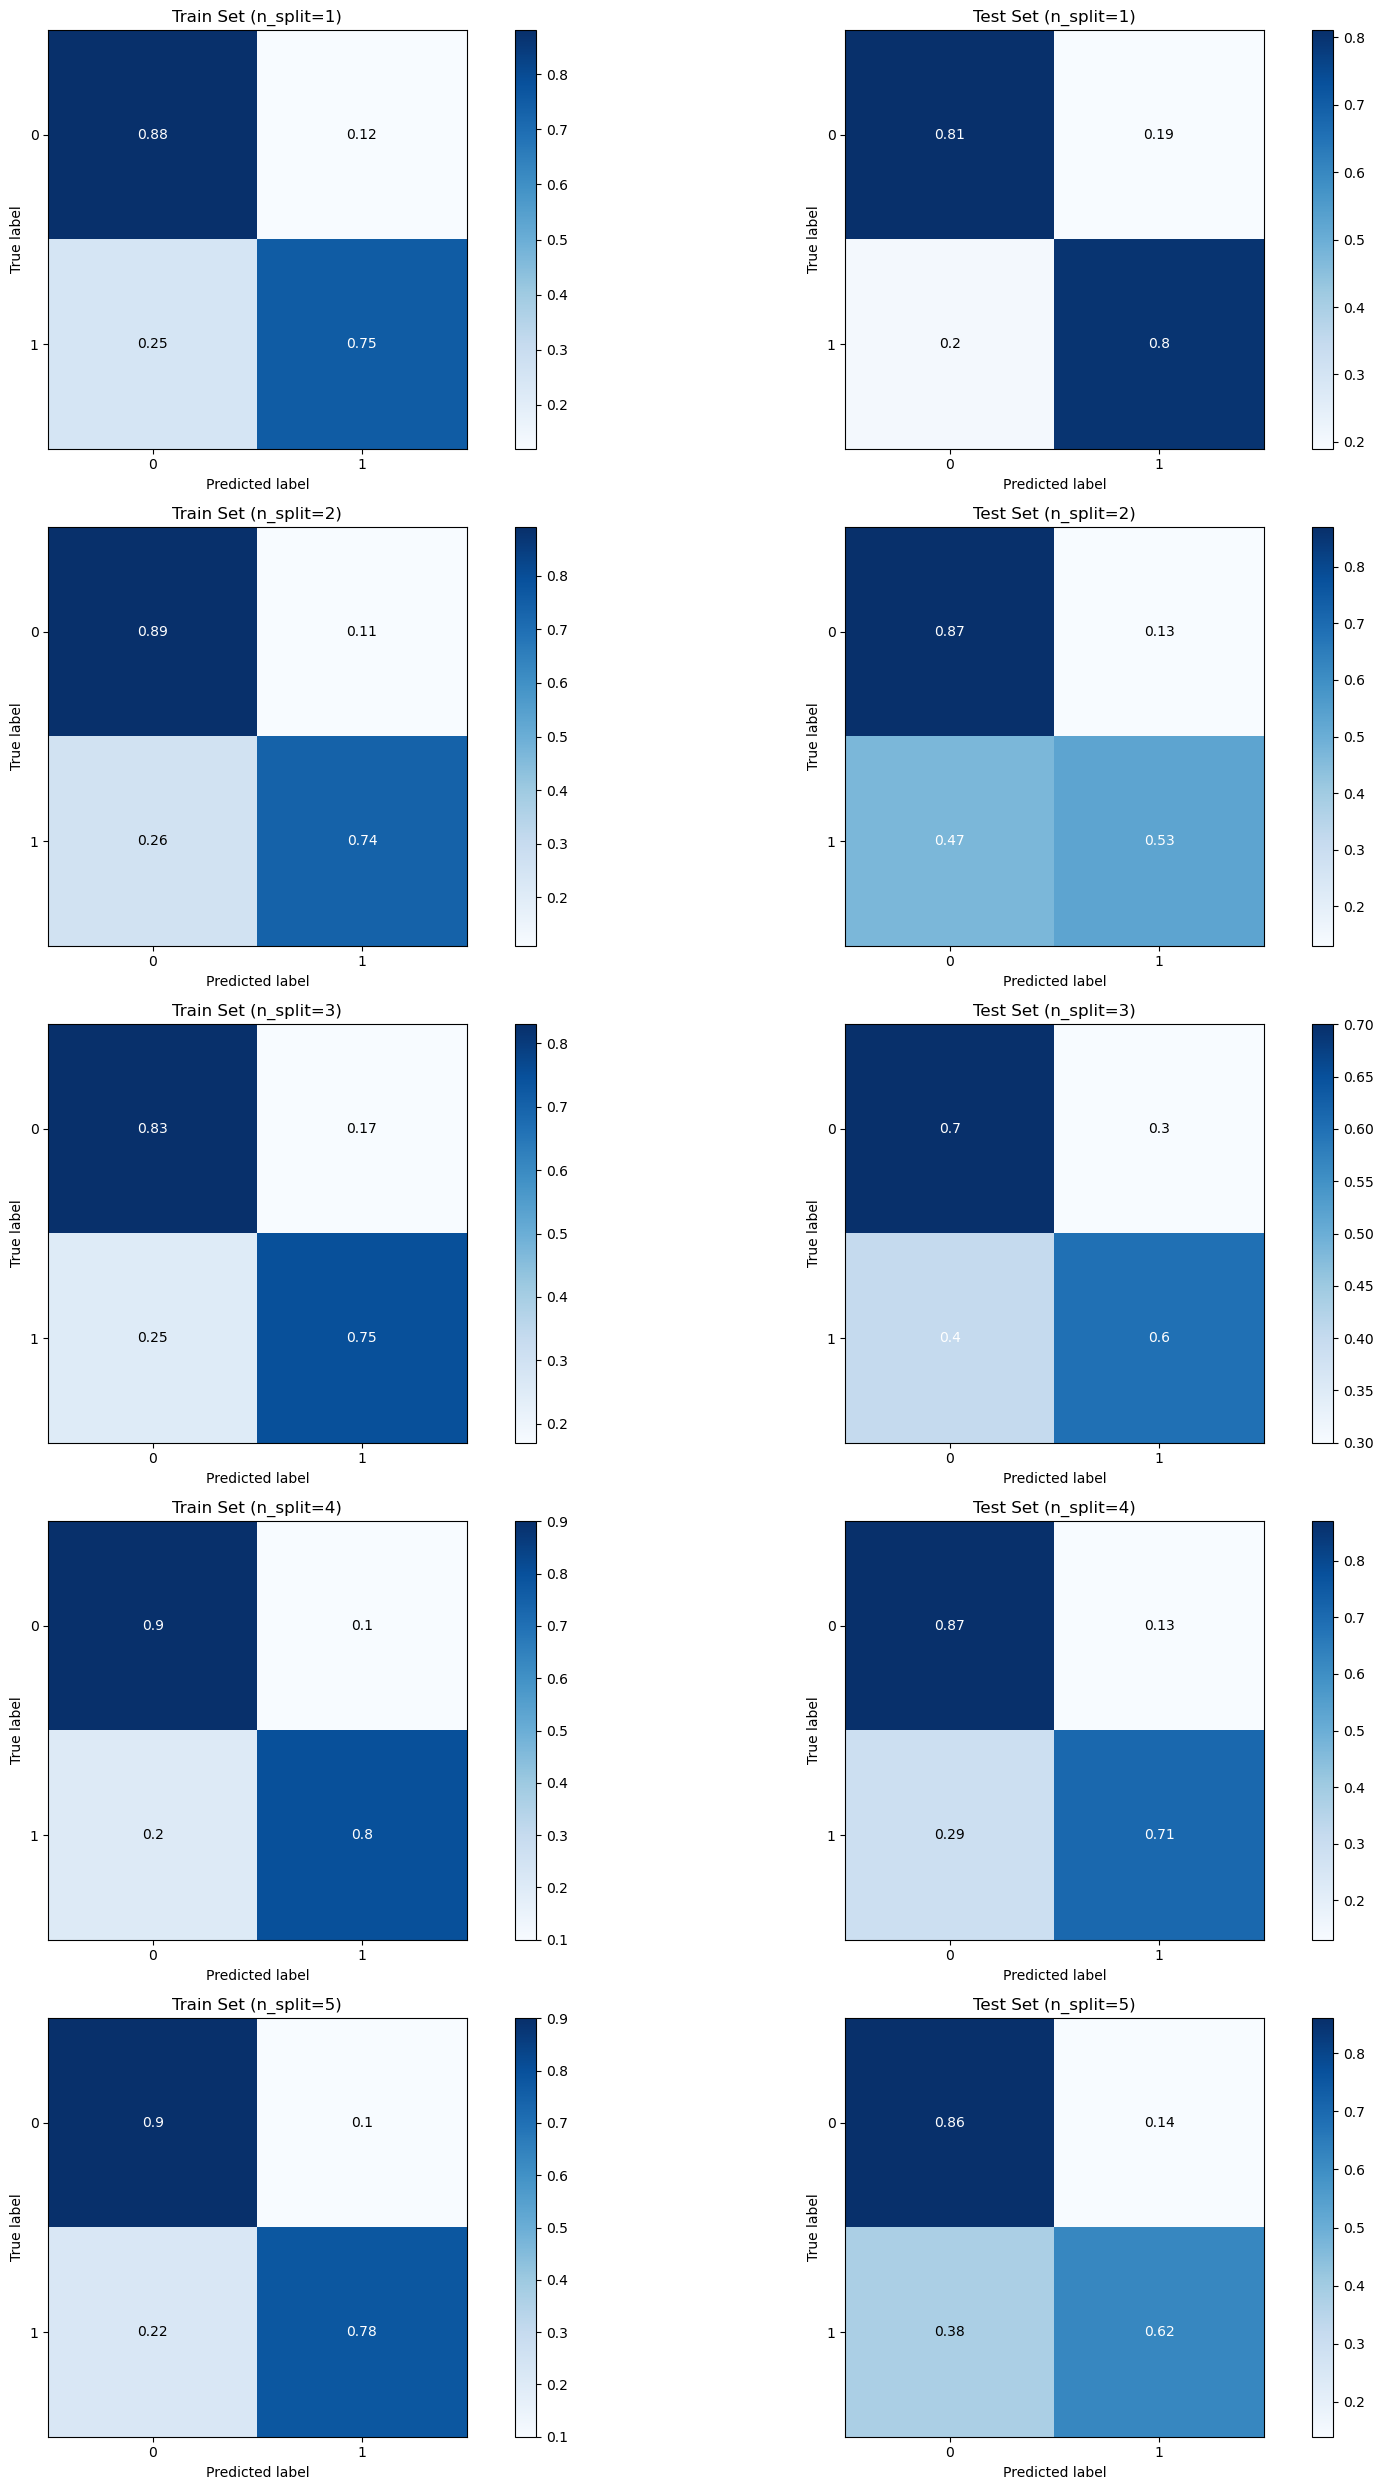

In [19]:
MyMultiTrainTester.plot_confusion(normalize=True)

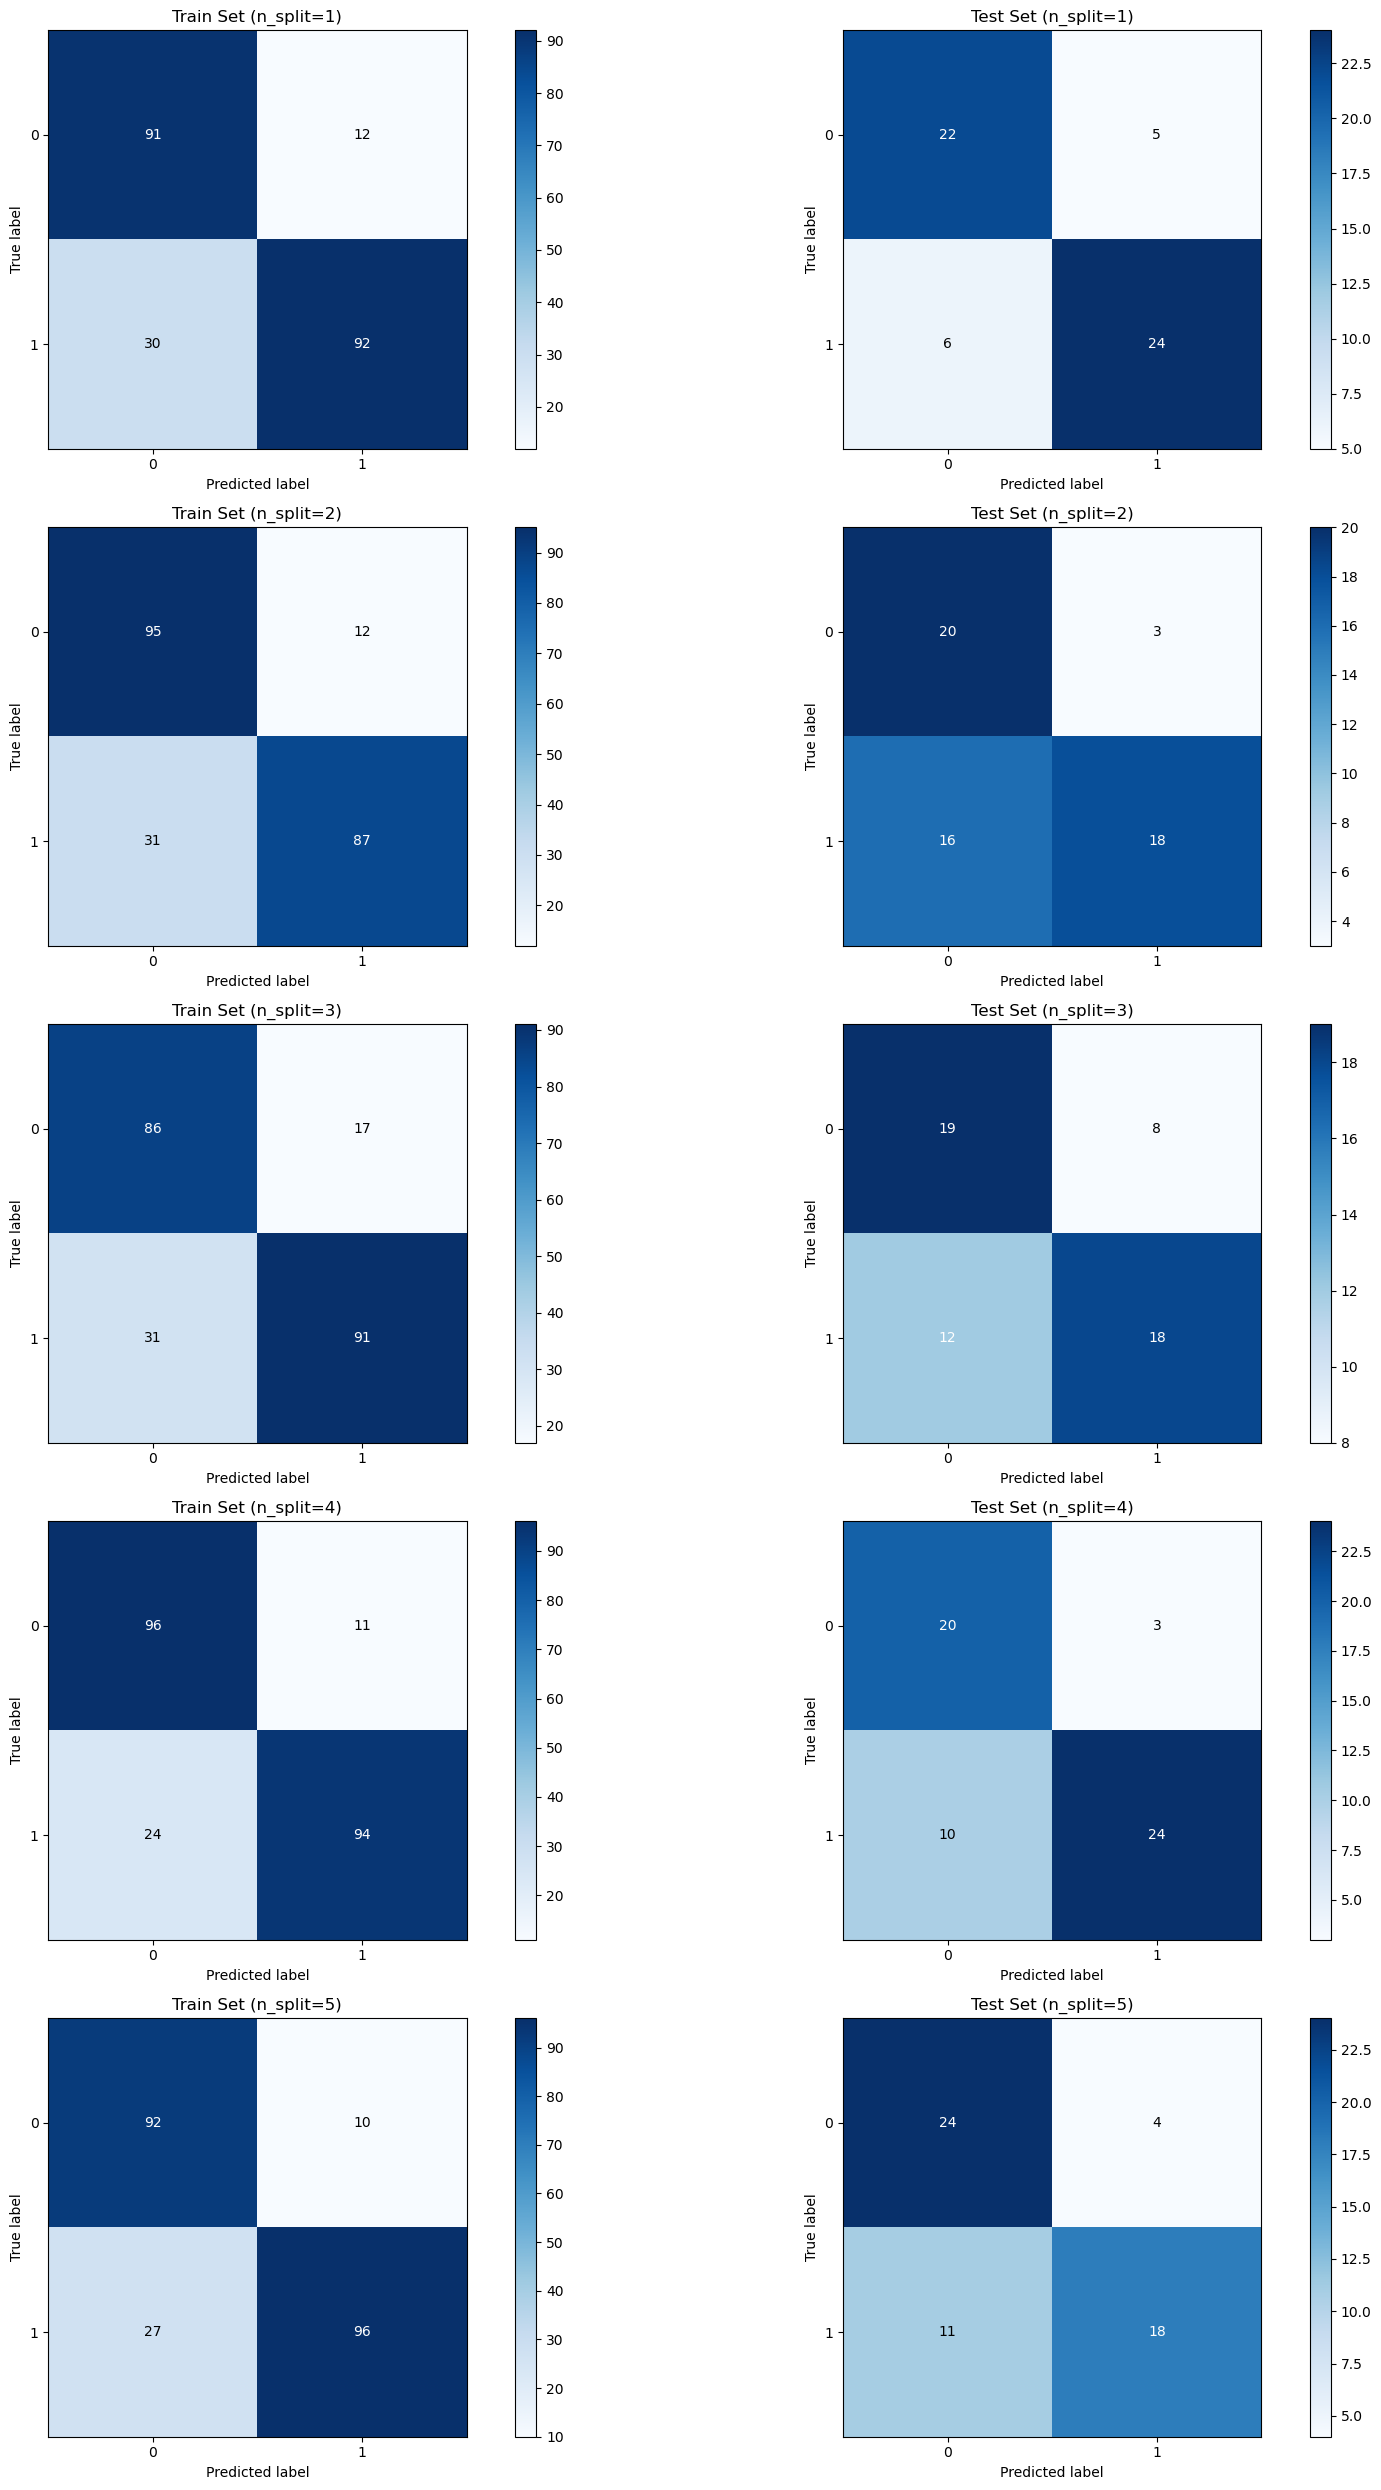

In [20]:
MyMultiTrainTester.plot_confusion(normalize=False)

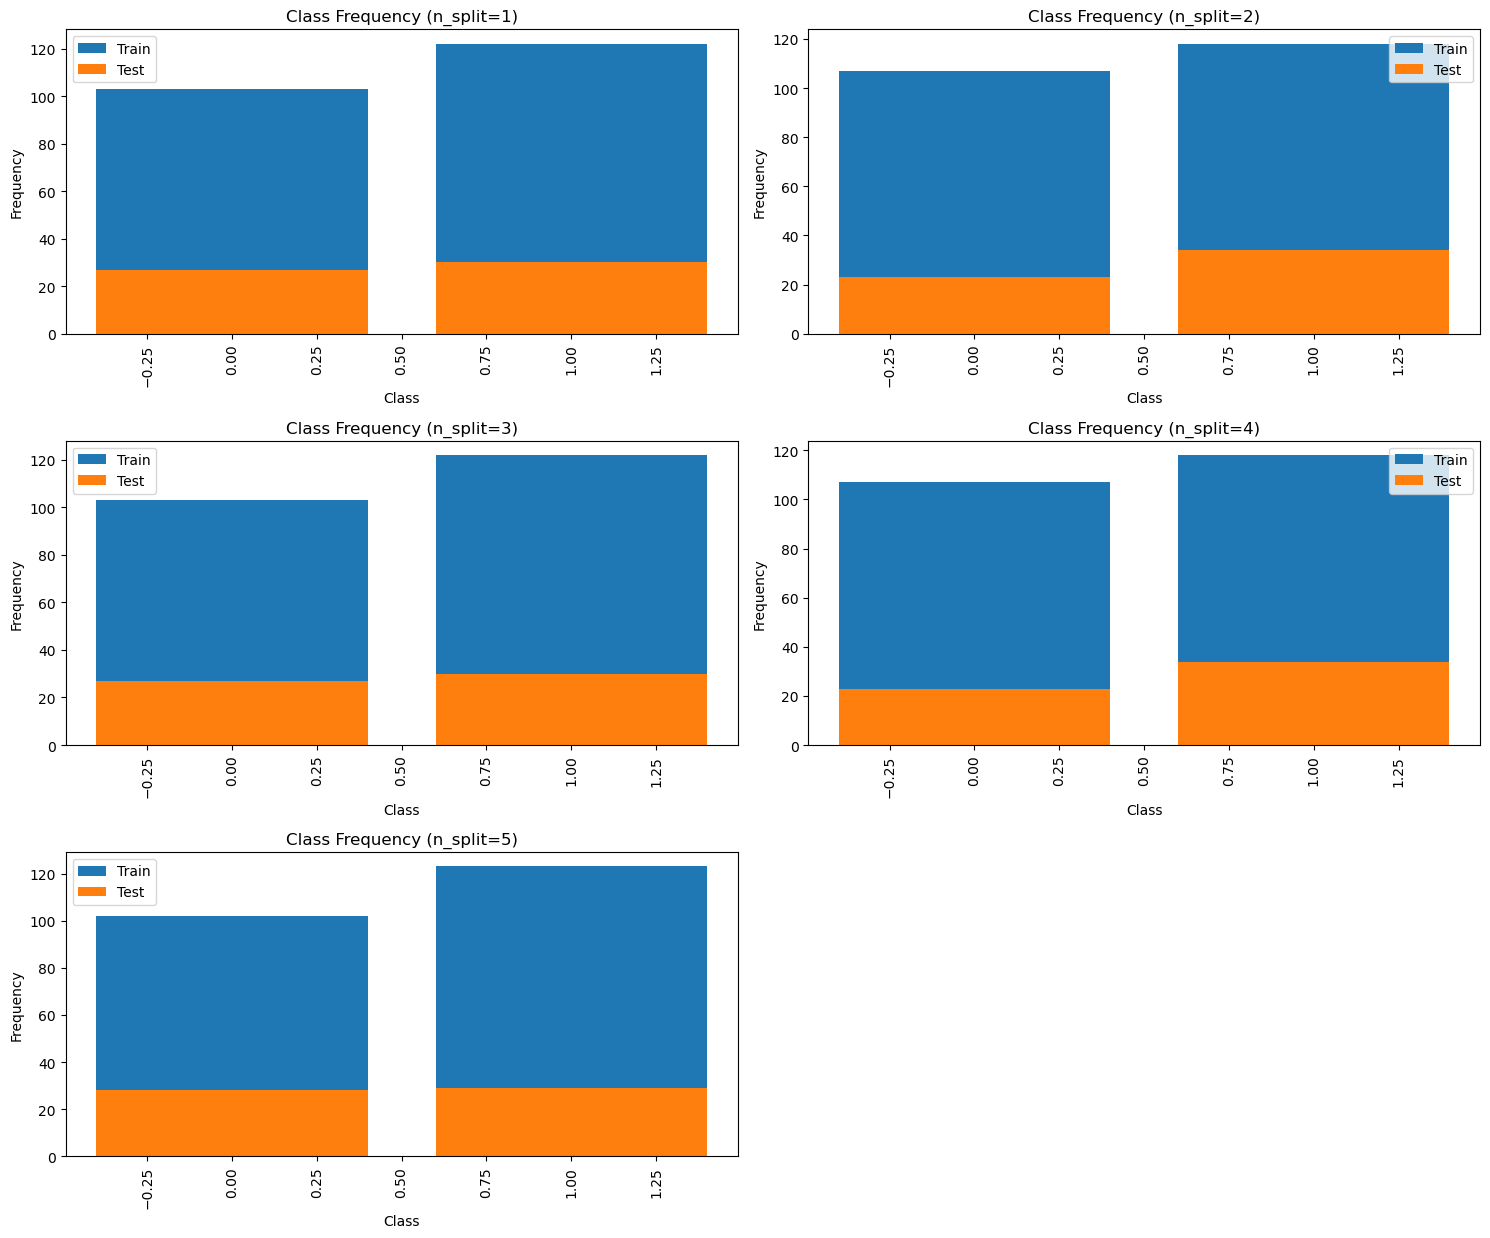

In [21]:
MyMultiTrainTester.plot_class_freq(normalize=True)

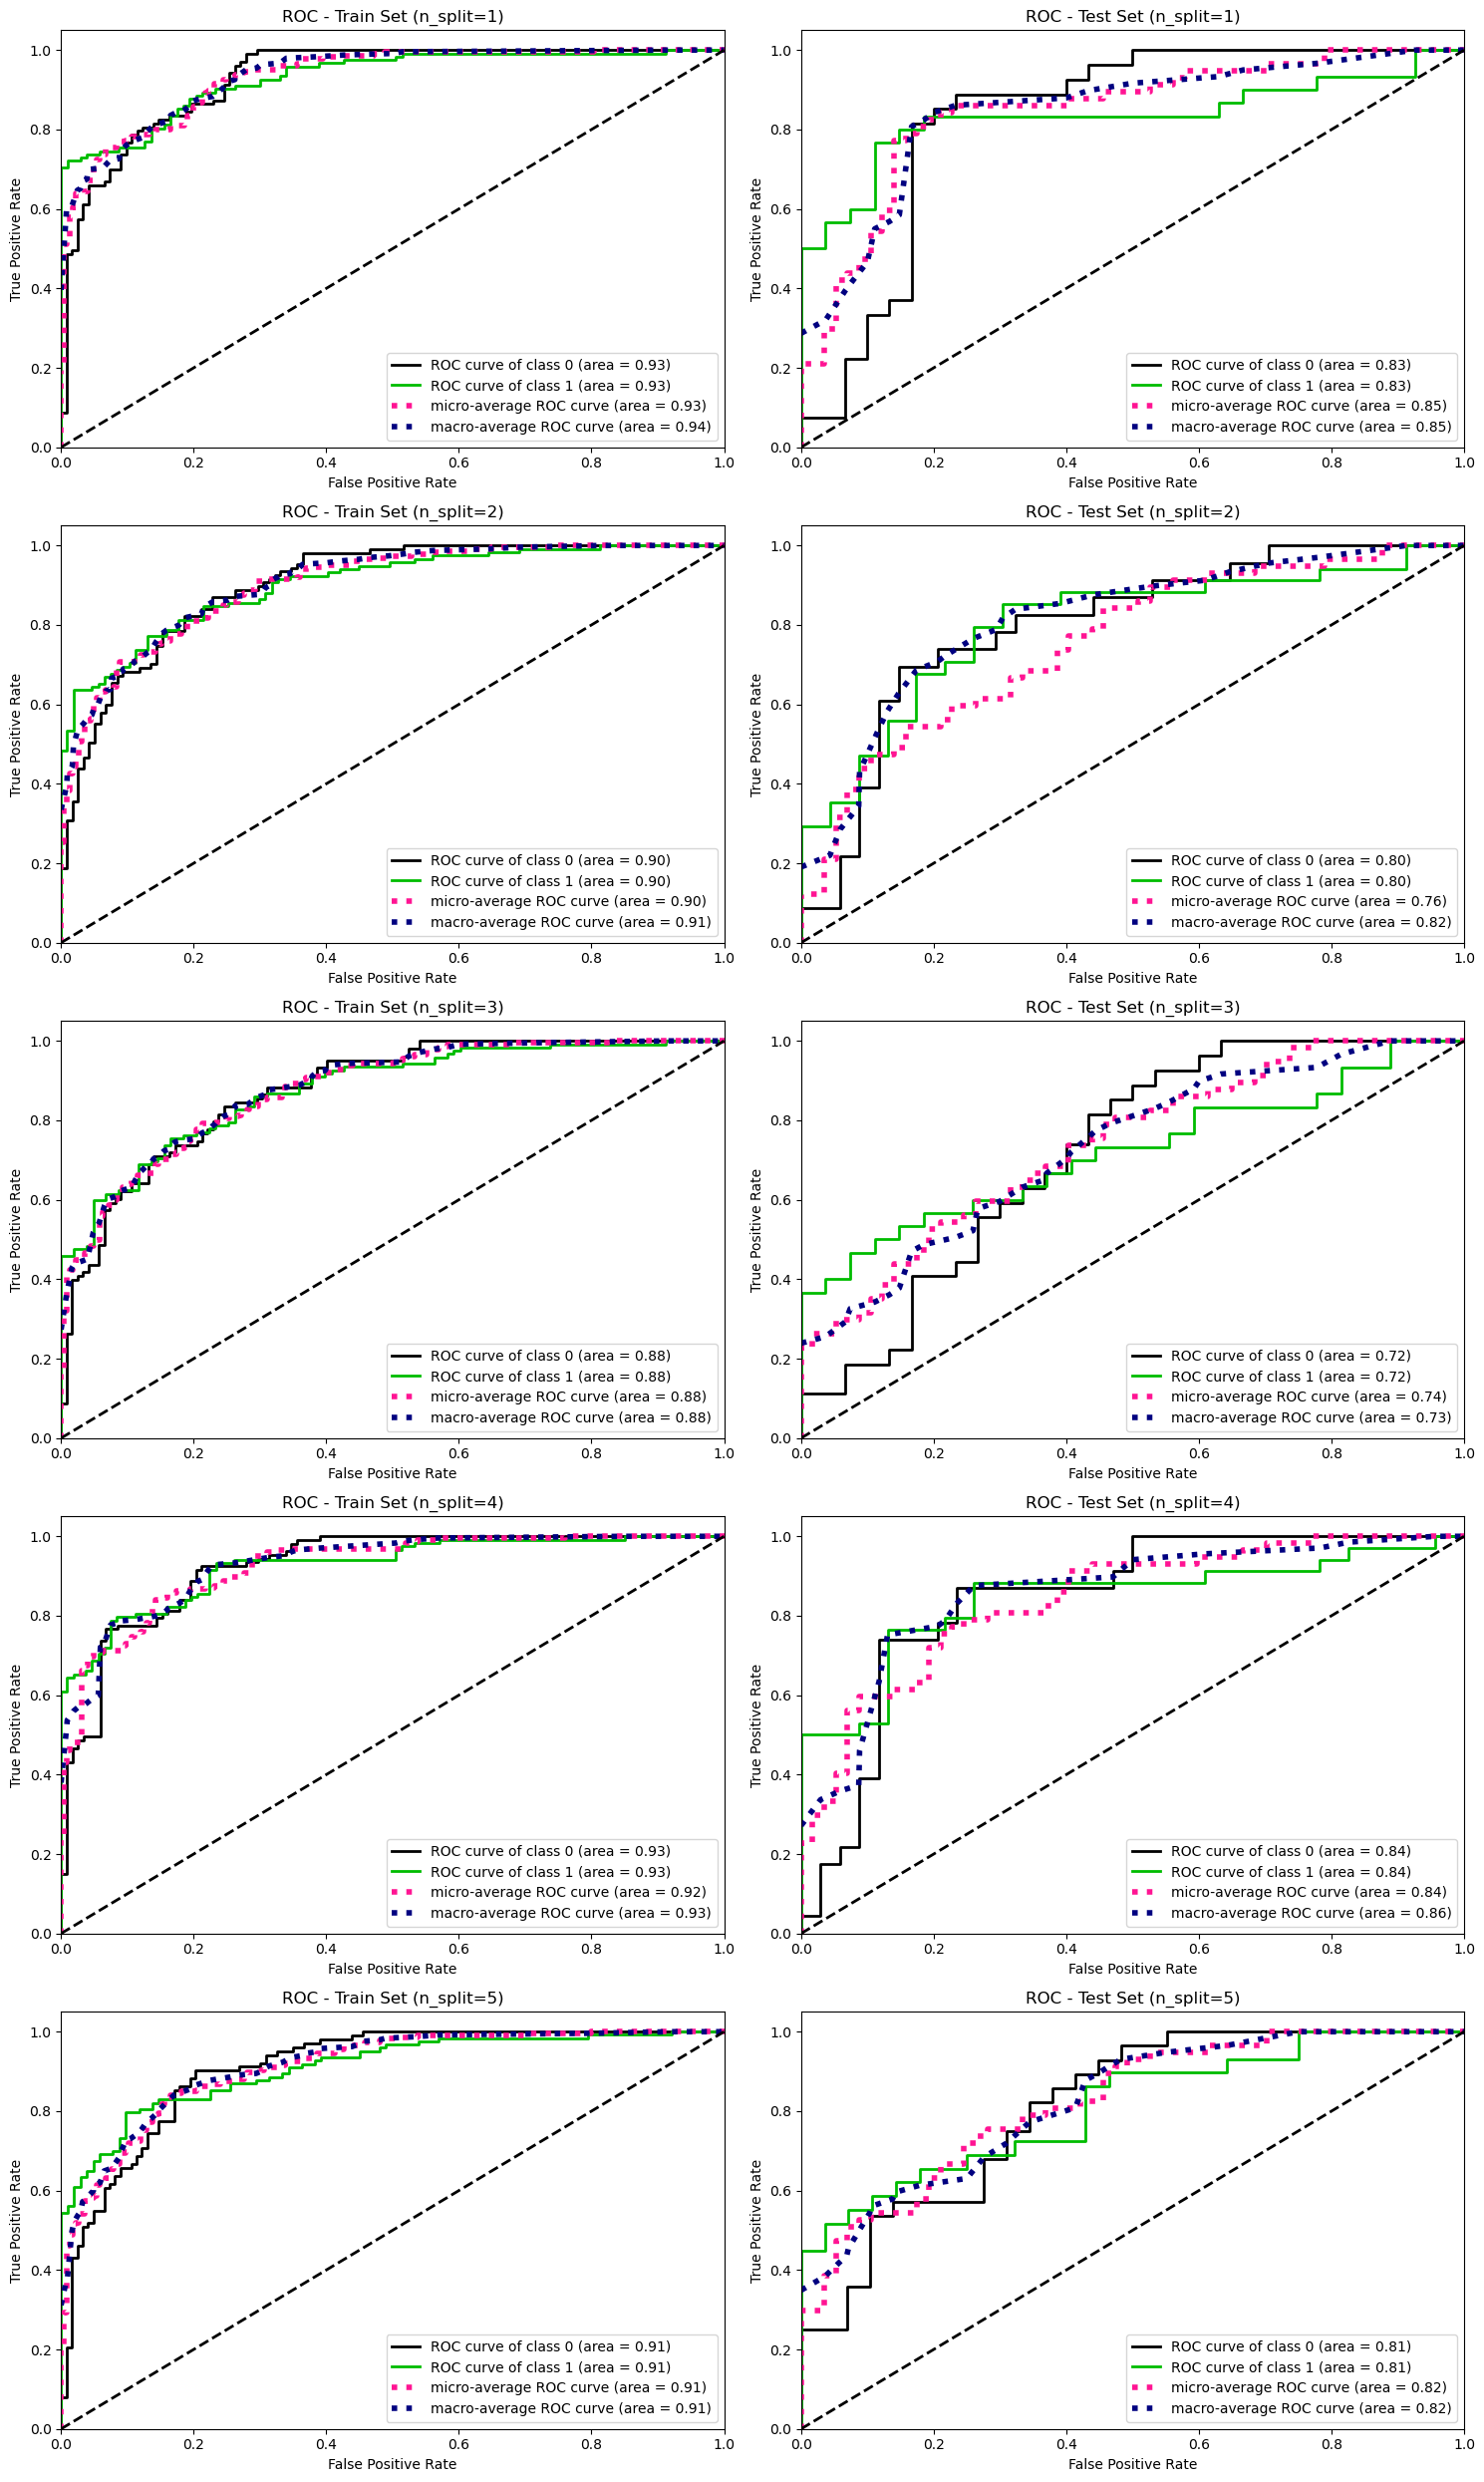

In [22]:
MyMultiTrainTester.plot_roc()

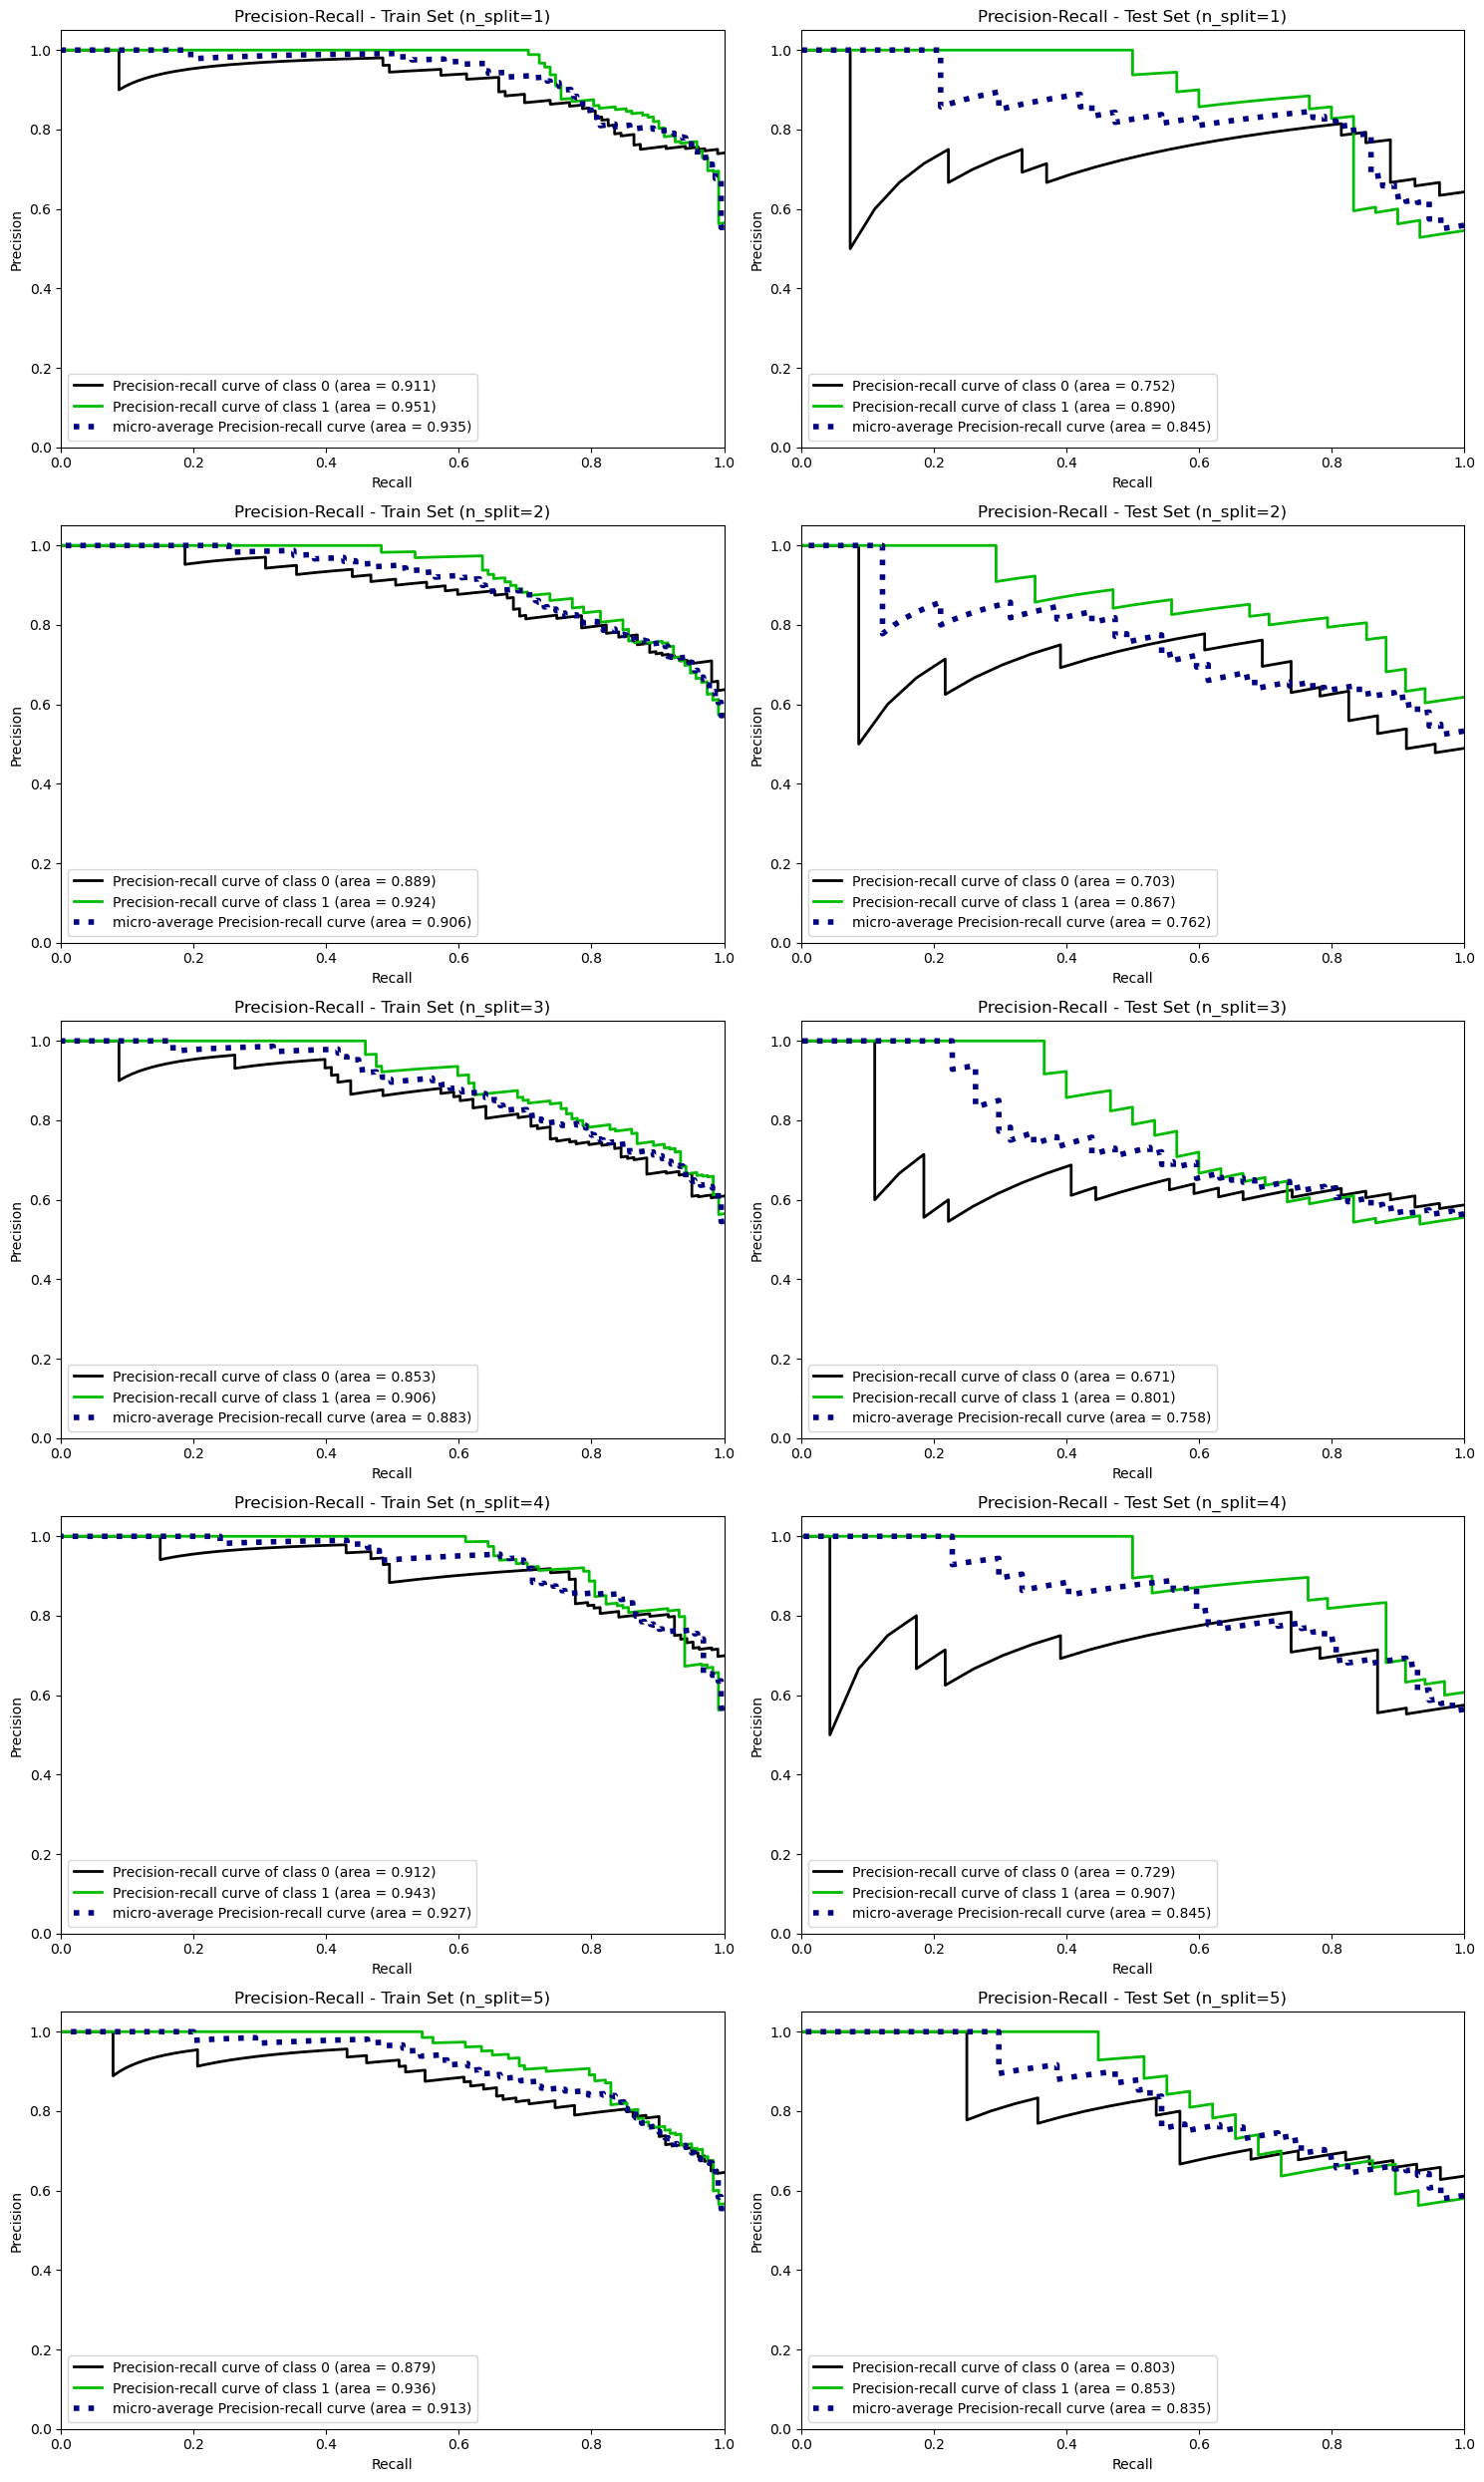

In [23]:
MyMultiTrainTester.plot_precrecall()